# Joint Field-Level Inference: Galaxies + CMB Lensing - Test Notebook

This notebook provides a **simple test** of the joint field-level inference pipeline (galaxies + CMB lensing) on CPU.

**Workflow**:
1. Create model with CMB lensing enabled
2. Generate synthetic observations (galaxies + CMB convergence)
3. Two-stage warmup (mesh only, then all parameters)
4. Sample with MCLMC
5. Visualize results

**For production runs**: Use `scripts/run_inference.py` with YAML config and GPU parallelization.

## 1. Imports and Setup

In [2]:
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import numpy as np
from blackjax.adaptation.mclmc_adaptation import MCLMCAdaptationState

from desi_cmb_fli.model import FieldLevelModel, default_config
from desi_cmb_fli.samplers import get_mclmc_run, get_mclmc_warmup

jax.config.update("jax_enable_x64", True)

print(f"JAX version: {jax.__version__}")
print(f"Backend: {jax.default_backend()}")
print(f"Devices: {jax.devices()}")

/pscratch/sd/j/jhawla/envs/desi-cmb-fli/lib/python3.11/site-packages/jax_cosmo/__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
ERROR:2025-11-14 07:10:09,256:jax._src.xla_bridge:473: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/pscratch/sd/j/jhawla/envs/desi-cmb-fli/lib/python3.11/site-packages/jax_plugins/xla_cuda12/__init__.py", line 201, in _version_check
    version = get_version()
              ^^^^^^^^^^^^^
RuntimeError: jaxlib/cuda/versions_helpers.cc:81: operation cusparseGetProperty(MAJOR_VERSION, &major) failed: The cuSPARSE library was not found.

The above exception was the direct cause of the following exception:



JAX version: 0.8.0
Backend: cpu
Devices: [CpuDevice(id=0)]


## 2. Model Configuration (Test Parameters with CMB Lensing)

In [3]:
# Test configuration (small mesh for fast CPU execution)
model_config = default_config.copy()
model_config["mesh_shape"] = (128, 128, 128)
model_config["box_shape"] = (200.0, 200.0, 200.0)  # Mpc/h
model_config["evolution"] = "lpt"
model_config["lpt_order"] = 2
model_config["a_obs"] = 0.5
model_config["gxy_density"] = 10  # [h^3/Mpc^3]


print("✓ CMB lensing ENABLED (joint inference)")
model_config["cmb_enabled"] = True  # Enable CMB in model
model_config["cmb_field_size_deg"] = 20.0  # Field size in degrees
model_config["cmb_field_npix"] = 128
model_config["cmb_z_source"] = 1100.0  # CMB redshift
model_config["cmb_noise_std"] = 0.0000001  # Convergence noise level
print(f"  Field: {model_config['cmb_field_size_deg']}° × {model_config['cmb_field_npix']}px")
print(f"  z_source: {model_config['cmb_z_source']}")
print(f"  Noise σ: {model_config['cmb_noise_std']}")

model = FieldLevelModel(**model_config)
print(model)

✓ CMB lensing ENABLED (joint inference)
  Field: 20.0° × 128px
  z_source: 1100.0
  Noise σ: 1e-07
# CONFIG
{'a_obs': 0.5,
 'box_shape': array([200., 200., 200.]),
 'cmb_enabled': True,
 'cmb_field_npix': 128,
 'cmb_field_size_deg': 20.0,
 'cmb_lensing_obs': None,
 'cmb_noise_std': 1e-07,
 'cmb_z_source': 1100.0,
 'evolution': 'lpt',
 'gxy_density': 10,
 'latents': {'Omega_m': {'group': 'cosmo',
                         'high': 1.0,
                         'label': '{\\Omega}_m',
                         'loc': 0.3111,
                         'loc_fid': 0.3111,
                         'low': 0.05,
                         'scale': 0.5,
                         'scale_fid': 0.02},
             'b1': {'group': 'bias',
                    'label': '{b}_1',
                    'loc': 1.0,
                    'loc_fid': 1.0,
                    'scale': 0.5,
                    'scale_fid': 0.04},
             'b2': {'group': 'bias',
                    'label': '{b}_2',
                

## 3. Generate Synthetic Truth (Galaxies + CMB)

In [4]:
# Truth parameters for synthetic data
truth_params = {
    "Omega_m": 0.3,
    "sigma8": 0.8,
    "b1": 1.0,
    "b2": 0.0,
    "bs2": 0.0,
    "bn2": 0.0,
}

seed = 28
truth = model.predict(
    samples=truth_params,
    hide_base=False,
    hide_samp=False,
    hide_det=False,
    frombase=True,
    rng=jr.key(seed),
)

print(f"Galaxy obs shape: {truth['obs'].shape}")
print(f"Mean count: {jnp.mean(truth['obs']):.4f}")
print(f"Std: {jnp.std(truth['obs']):.4f}")

print(f"\nCMB κ obs shape: {truth['kappa_obs'].shape}")
print(f"Mean κ: {jnp.mean(truth['kappa_obs']):.6f}")
print(f"Std κ: {jnp.std(truth['kappa_obs']):.6f}")
if "kappa_pred" in truth:
    print(f"Mean κ_pred: {jnp.mean(truth['kappa_pred']):.6f}")

Galaxy obs shape: (128, 128, 128)
Mean count: 0.9999
Std: 3.7654

CMB κ obs shape: (128, 128)
Mean κ: 0.000217
Std κ: 0.000383
Mean κ_pred: 0.000217


## 4. Visualize Observations (Galaxies + CMB)

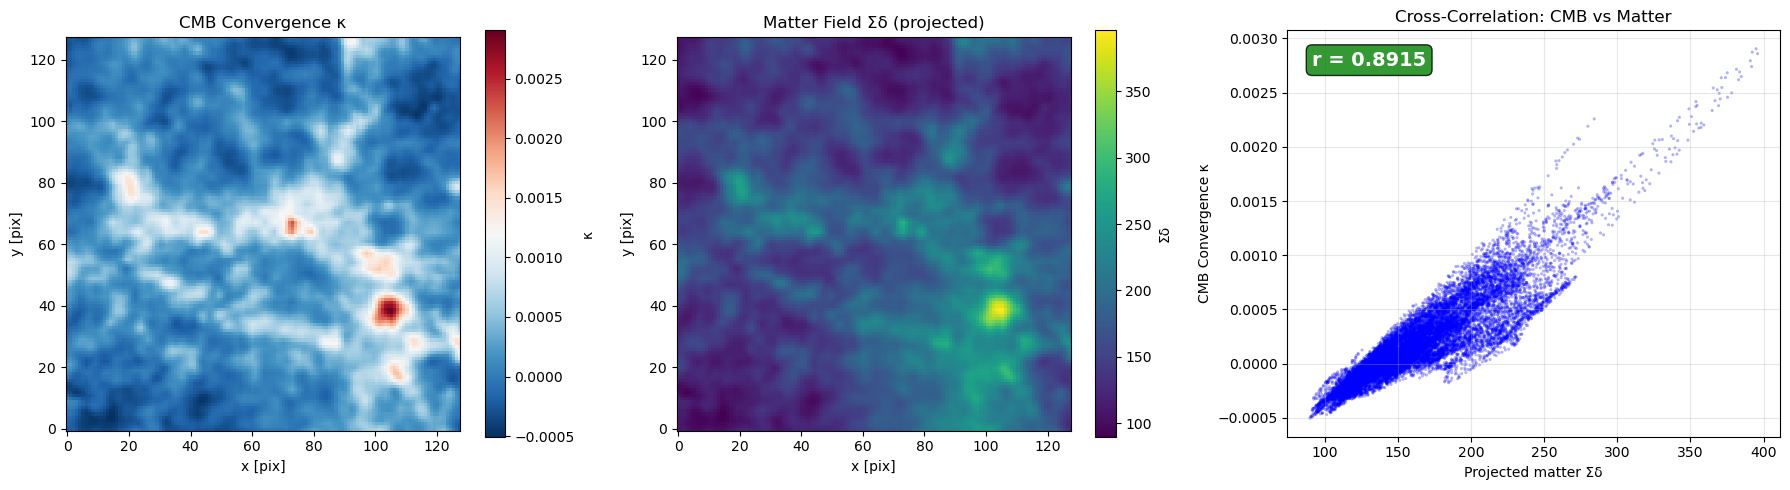


CROSS-CORRELATION ANALYSIS (CMB-Matter)
Correlation κ vs matter field: r = 0.8915
Field size: 20.0° × 128px
Projected matter: mean=166.5066, std=41.1788
CMB κ: mean=0.000217, std=0.000383


In [7]:
from scipy.ndimage import map_coordinates

# Get the CMB projection coordinates (same as in convergence_Born)
field_size_deg = model_config["cmb_field_size_deg"]
field_npix = model_config["cmb_field_npix"]
box_size = model_config["box_shape"][0]
mesh_shape = model_config["mesh_shape"][0]

# Create angular coordinate grid (matching CMB projection)
theta = np.linspace(-field_size_deg / 2, field_size_deg / 2, field_npix, endpoint=False)
rowgrid, colgrid = np.meshgrid(theta, theta, indexing="ij")
coords = np.array(np.stack([rowgrid, colgrid], axis=0)) * (np.pi / 180.0)

# Distance planes
dx = box_size / mesh_shape
dz = box_size / mesh_shape
r_planes = (np.arange(mesh_shape) + 0.5) * dz

# Project the unbiased matter mesh along the LOS so it matches κ
default_field = np.array(truth["obs"])
matter_field = np.array(truth.get("matter_mesh", default_field))
matter_proj = np.zeros((field_npix, field_npix))

for i in range(mesh_shape):
    r = r_planes[i]
    pixel_coords = coords * r / dx + mesh_shape / 2.0
    plane = map_coordinates(matter_field[:, :, i], pixel_coords, order=1, mode="wrap")
    matter_proj += plane

# Compute cross-correlation
kappa_flat = np.array(truth["kappa_obs"]).flatten()
matter_proj_flat = matter_proj.flatten()

corr_cross = np.corrcoef(kappa_flat, matter_proj_flat)[0, 1]

# Visualize cross-correlation
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. CMB convergence
im0 = axes[0].imshow(truth["kappa_obs"], origin="lower", cmap="RdBu_r")
axes[0].set_title("CMB Convergence κ")
axes[0].set_xlabel("x [pix]")
axes[0].set_ylabel("y [pix]")
plt.colorbar(im0, ax=axes[0], label="κ")

# 2. Matter field (projected)
im1 = axes[1].imshow(matter_proj, origin="lower", cmap="viridis")
axes[1].set_title("Matter Field Σδ (projected)")
axes[1].set_xlabel("x [pix]")
axes[1].set_ylabel("y [pix]")
plt.colorbar(im1, ax=axes[1], label="Σδ")

# 3. Scatter plot: κ vs projected matter
axes[2].scatter(matter_proj_flat, kappa_flat, alpha=0.3, s=5, c="blue", edgecolors="none")
axes[2].set_xlabel("Projected matter Σδ")
axes[2].set_ylabel("CMB Convergence κ")
axes[2].set_title("Cross-Correlation: CMB vs Matter")
axes[2].grid(True, alpha=0.3)

# Add correlation coefficient
color = "green" if corr_cross > 0.8 else ("orange" if corr_cross > 0.5 else "red")
axes[2].text(
    0.05,
    0.95,
    f"r = {corr_cross:.4f}",
    transform=axes[2].transAxes,
    bbox={"boxstyle": "round", "facecolor": color, "alpha": 0.8, "edgecolor": "black"},
    verticalalignment="top",
    fontsize=14,
    fontweight="bold",
    color="white",
)

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("CROSS-CORRELATION ANALYSIS (CMB-Matter)")
print("=" * 60)
print(f"Correlation κ vs matter field: r = {corr_cross:.4f}")
print(f"Field size: {field_size_deg}° × {field_npix}px")
print(f"Projected matter: mean={matter_proj.mean():.4f}, std={matter_proj.std():.4f}")
print(f"CMB κ: mean={np.array(truth['kappa_obs']).mean():.6f}, std={np.array(truth['kappa_obs']).std():.6f}")
print("=" * 60)

## 5. MCLMC Inference (Following Benchmark)

We follow the exact structure from benchmark-field-level:
1. **Stage 1**: Warmup mesh only (2^10 steps, cosmo/bias fixed at fiducial)
2. **Stage 2**: Warmup all parameters (minimal steps for testing)
3. **Stage 3**: Sample (minimal samples for testing)

**Note**: This is a minimal test. For production, use `scripts/run_inference.py`.

### Stage 1: Warmup Mesh Only

In [12]:
# Condition model with obs + fiducial cosmo/bias (freeze non-mesh params)
condition_dict = {"obs": truth["obs"]}

condition_dict["kappa_obs"] = truth["kappa_obs"]
print("✓ Model conditioned on galaxy obs + CMB κ obs")

model.reset()
model.condition(condition_dict | model.loc_fid, frombase=True)
model.block()

# Initialize from Kaiser posterior (use true overdensity so mean count ≃ 1)
delta_obs = truth["obs"] / jnp.mean(truth["obs"]) - 1.0
init_params_ = model.kaiser_post(jr.key(45), delta_obs=delta_obs)
init_mesh_ = {k: init_params_[k] for k in ["init_mesh_"]}

# Warmup mesh only (2^10 steps, as in benchmark)
print("Warming mesh only (2^10 steps, cosmo/bias fixed)...")
warmup_mesh_fn = get_mclmc_warmup(
    model.logpdf,
    n_steps=2**10,
    config=None,
    desired_energy_var=1e-6,
    diagonal_preconditioning=False,
)

state_mesh, config_mesh = warmup_mesh_fn(jr.key(43), init_mesh_)

print("✓ Mesh warmup done")
print(f"  Logdens: {state_mesh.logdensity:.2f}")
print(f"  L: {config_mesh.L:.6f}")
print(f"  step_size: {config_mesh.step_size:.6f}")

# Update init params with warmed mesh
init_params_ |= state_mesh.position

✓ Model conditioned on galaxy obs + CMB κ obs
Warming mesh only (2^10 steps, cosmo/bias fixed)...
Warming mesh only (2^10 steps, cosmo/bias fixed)...
Performed 1024.0 adaptation steps
✓ Mesh warmup done
Performed 1024.0 adaptation steps
✓ Mesh warmup done
  Logdens: -56929110.42
  L: 10.525586
  step_size: 0.036645
  Logdens: -56929110.42
  L: 10.525586
  step_size: 0.036645


### Stage 2: Warmup All Parameters

In [13]:
# Reset and condition with obs only (all params free)
model.reset()
model.condition(condition_dict)
model.block()

# Warmup all params (keep short for CPU demo)
num_warmup = 1024
print(f"Warming all params ({num_warmup} steps)...")

warmup_all_fn = get_mclmc_warmup(
    model.logpdf,
    n_steps=num_warmup,
    config=None,
    desired_energy_var=5e-4,
    diagonal_preconditioning=False,
)

state, config = warmup_all_fn(jr.key(43), init_params_)

print("✓ Full warmup done")
print(f"  Logdens: {state.logdensity:.2f}")
print(f"  Adapted L: {config.L:.6f}")
print(f"  step_size: {config.step_size:.6f}")

# Recalculate L (benchmark approach for efficiency)
eval_per_ess = 1e3
recalc_L = 0.4 * eval_per_ess / 2 * config.step_size

config = MCLMCAdaptationState(
    L=recalc_L, step_size=config.step_size, inverse_mass_matrix=config.inverse_mass_matrix
)

print(f"\n  Recalculated L: {recalc_L:.6f}")

Warming all params (1024 steps)...
Performed 1024.0 adaptation steps
✓ Full warmup done
Performed 1024.0 adaptation steps
✓ Full warmup done
  Logdens: -39616630.81
  Adapted L: 3.170599
  step_size: 0.017794

  Recalculated L: 3.558819
  Logdens: -39616630.81
  Adapted L: 3.170599
  step_size: 0.017794

  Recalculated L: 3.558819


### Stage 3: Sample

In [14]:
# Sample (minimal for testing)
num_samples = 1024
print(f"Sampling {num_samples} steps...")

run_fn = get_mclmc_run(
    model.logpdf,
    n_samples=num_samples,
    thinning=1,
    progress_bar=False,  # Disable progress bar for notebook compatibility
)

state, samples_dict = run_fn(jr.key(42), state, config)

print("\n✓ Sampling done!")
print(f"  Mean MSE/dim: {jnp.mean(samples_dict['mse_per_dim']):.6e}")
print(f"  Final logdensity: {state.logdensity:.2f}")

# Extract parameter samples (exclude diagnostics)
samples = {}
param_names = [k for k in samples_dict.keys() if k not in ["logdensity", "mse_per_dim"]]
for p in param_names:
    samples[p] = np.array(samples_dict[p])  # move to host memory immediately

print(f"\nSampled parameters: {param_names}")

Sampling 1024 steps...

✓ Sampling done!

✓ Sampling done!
  Mean MSE/dim: 1.552999e-03
  Final logdensity: -35310305.85

Sampled parameters: ['Omega_m_', 'b1_', 'b2_', 'bn2_', 'bs2_', 'init_mesh_', 'sigma8_', 'n_evals']
  Mean MSE/dim: 1.552999e-03
  Final logdensity: -35310305.85

Sampled parameters: ['Omega_m_', 'b1_', 'b2_', 'bn2_', 'bs2_', 'init_mesh_', 'sigma8_', 'n_evals']


## 6. Analyze Results

In [15]:
# Compare recovered parameters to truth
comp_params = ["Omega_m", "sigma8", "b1", "b2", "bs2", "bn2"]

print("Parameter recovery:")
print(f"{'Param':<10} {'Truth':<10} {'Mean':<10} {'Std':<10} {'Bias(σ)':<10}")
print("-" * 60)

for p in comp_params:
    pk = p + "_"
    if pk in samples:
        vals = samples[pk]  # Already 1D for single chain
        mean, std = np.mean(vals), np.std(vals)
        truth_val = truth_params[p]
        bias = (mean - truth_val) / std if std > 0 else 0
        print(f"{p:<10} {truth_val:<10.4f} {mean:<10.4f} {std:<10.4f} {bias:<10.2f}")

Parameter recovery:
Param      Truth      Mean       Std        Bias(σ)   
------------------------------------------------------------
Omega_m    0.3000     -1.3976    0.3768     -4.51     
sigma8     0.8000     -0.0003    0.0002     -4056.59  
b1         1.0000     1.1335     1.5562     0.09      
b2         0.0000     -21.7455   1.9785     -10.99    
bs2        0.0000     0.2565     0.7223     0.36      
bn2        0.0000     18.3058    4.3402     4.22      


## 7. Visualizations (Cosmological Parameters)

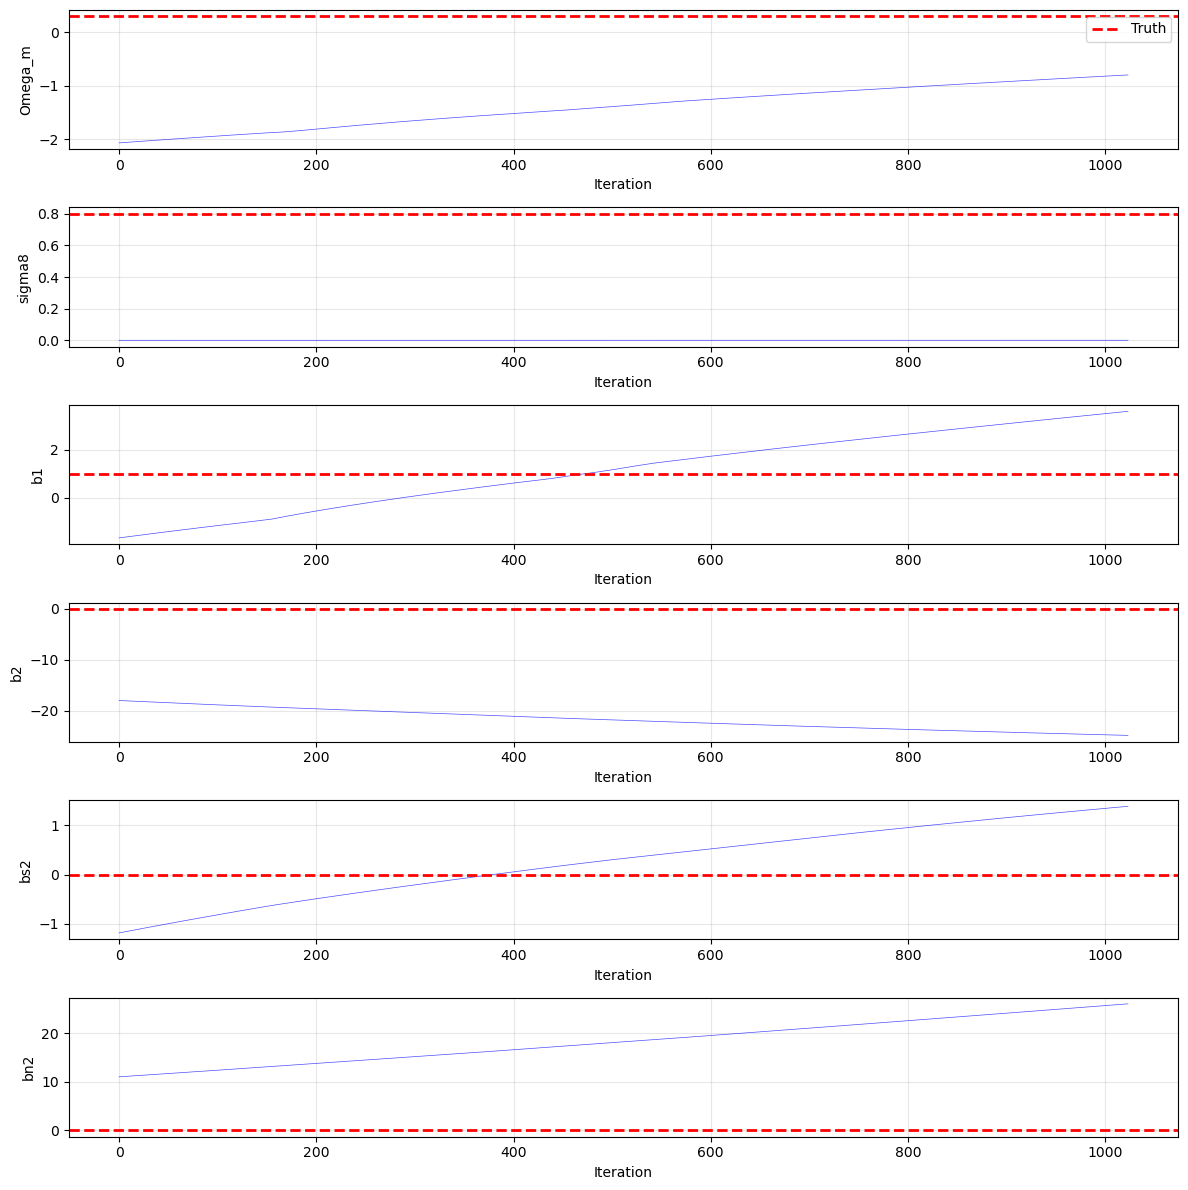

In [16]:
# Trace plots
fig, axes = plt.subplots(len(comp_params), 1, figsize=(12, 2 * len(comp_params)))

for i, p in enumerate(comp_params):
    pk = p + "_"
    if pk in samples:
        ax = axes[i]
        ax.plot(samples[pk], alpha=0.7, lw=0.5, color="blue")
        ax.axhline(truth_params[p], color="red", ls="--", lw=2, label="Truth")
        ax.set_ylabel(p)
        ax.set_xlabel("Iteration")
        if i == 0:
            ax.legend(loc="upper right")
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

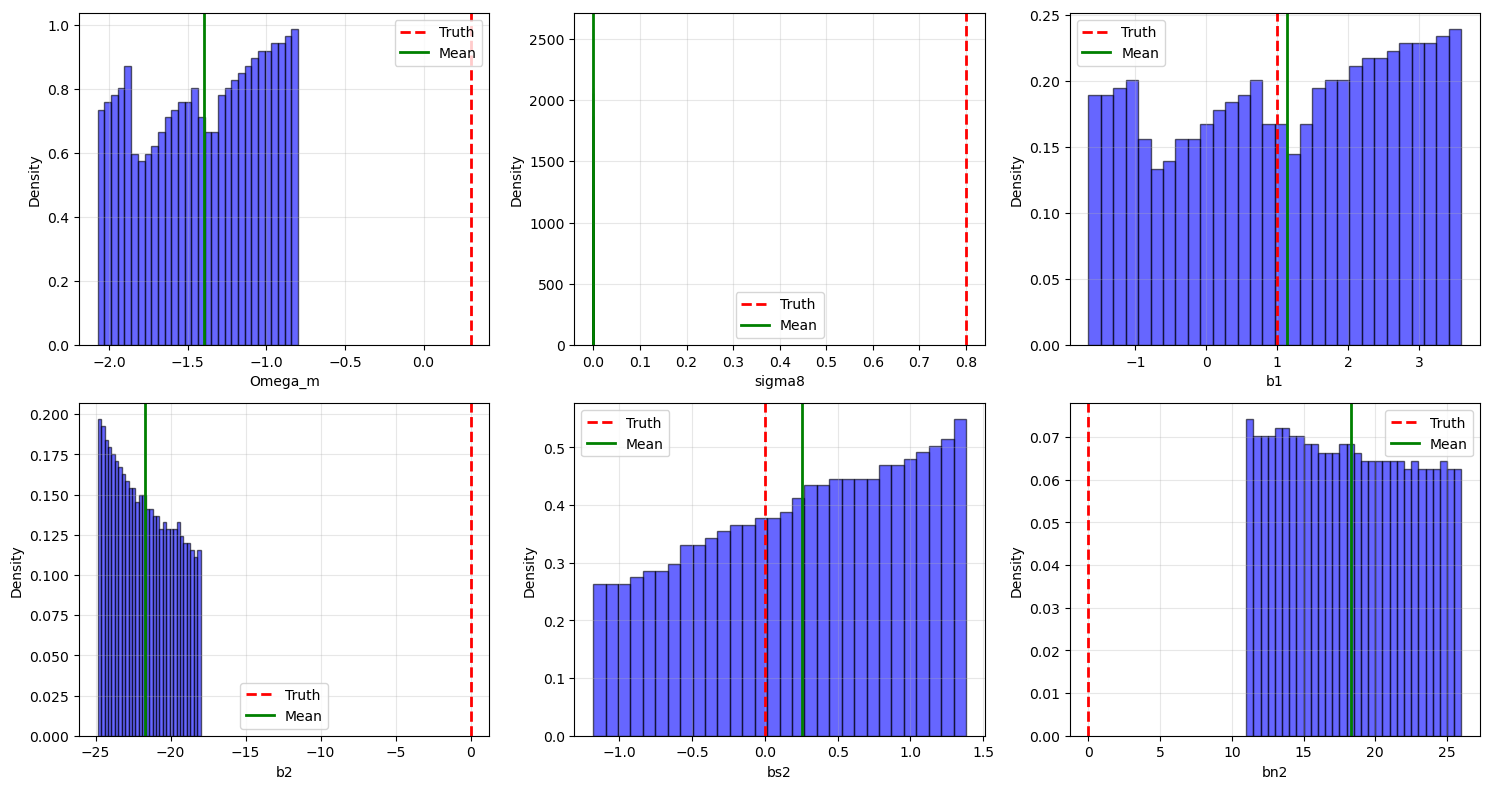

In [17]:
# Posterior distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, p in enumerate(comp_params):
    pk = p + "_"
    if pk in samples:
        ax = axes[i]
        vals = samples[pk]

        ax.hist(vals, bins=30, density=True, alpha=0.6, color="blue", edgecolor="black")
        ax.axvline(truth_params[p], color="red", ls="--", lw=2, label="Truth")
        ax.axvline(np.mean(vals), color="green", ls="-", lw=2, label="Mean")

        ax.set_xlabel(p)
        ax.set_ylabel("Density")
        ax.legend()
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

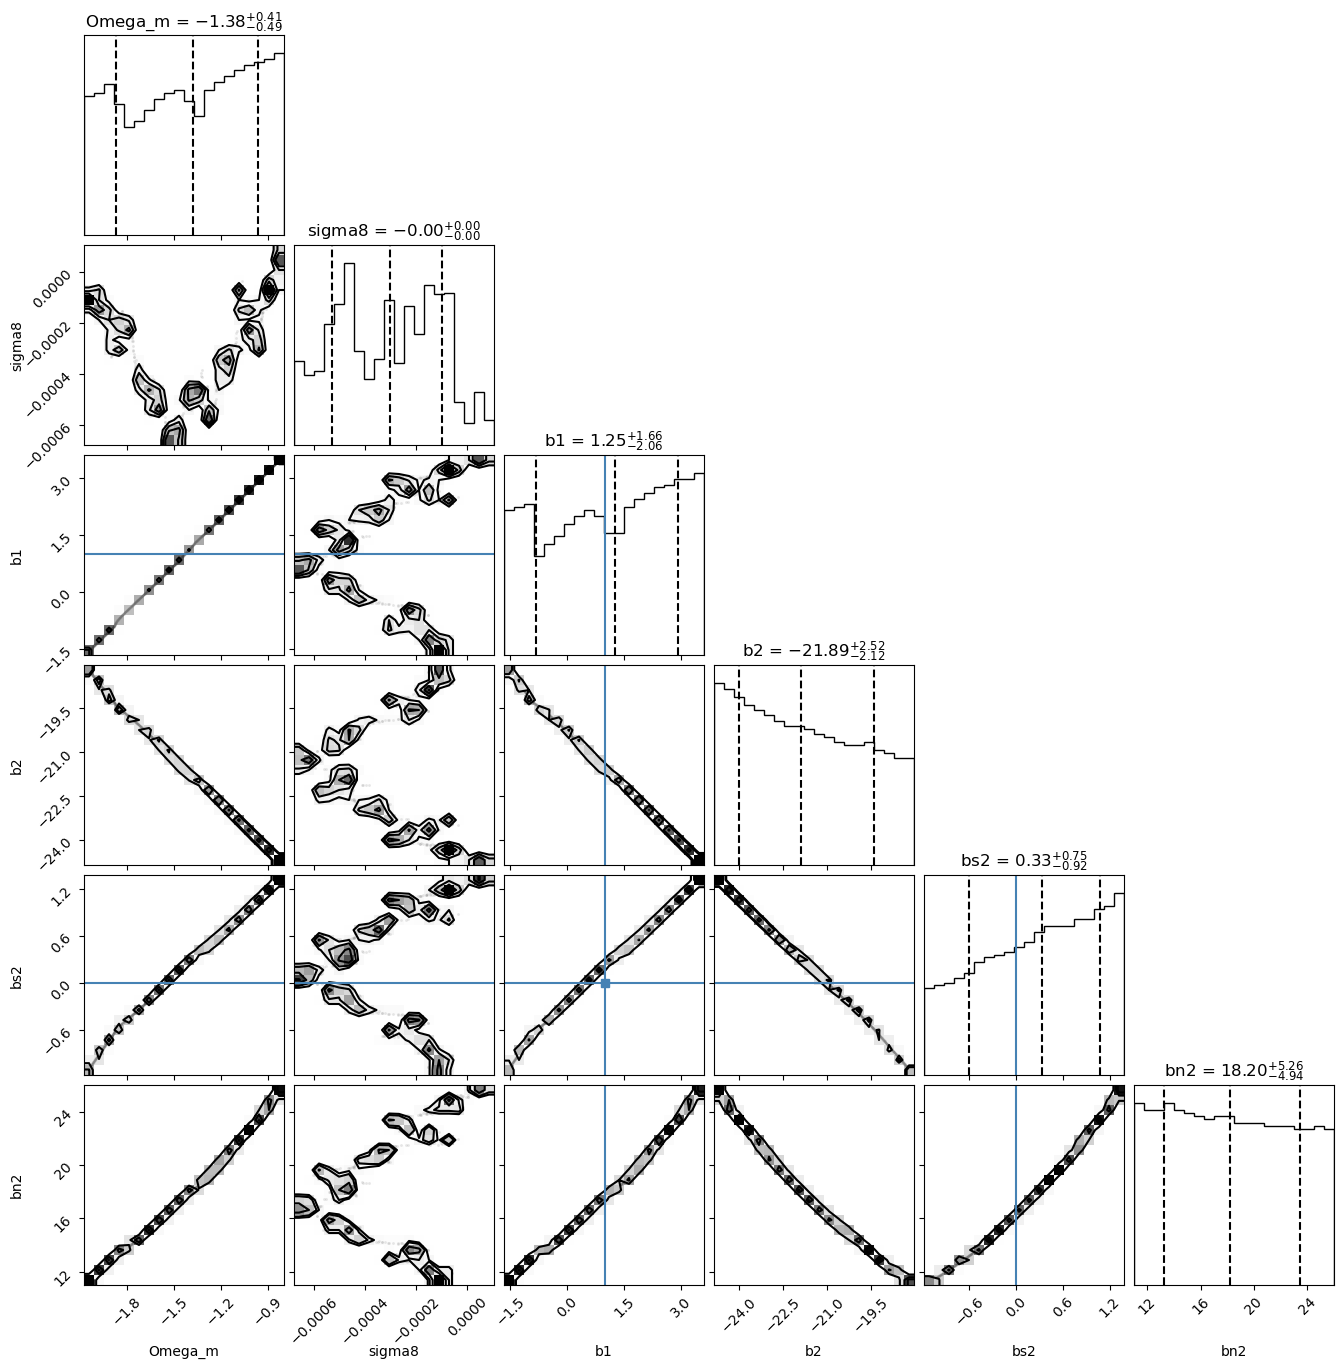

In [18]:
# Corner plot (optional)
try:
    import corner

    labels, data_list, truths = [], [], []
    for p in comp_params:
        pk = p + "_"
        if pk in samples:
            labels.append(p)
            data_list.append(samples[pk])
            truths.append(truth_params[p])

    data = np.column_stack(data_list)
    fig = corner.corner(
        data,
        labels=labels,
        truths=truths,
        quantiles=[0.16, 0.5, 0.84],
        show_titles=True,
        title_kwargs={"fontsize": 12},
    )
    plt.show()

except ImportError:
    print("⚠️  Corner plot requires 'corner' package. Install with: pip install corner")

## Summary

This notebook now mirrors the production joint pipeline while remaining light enough for a single CPU run:

1. ✅ Build a 12³ LPT model with CMB lensing enabled and generate synthetic galaxies + κ using the same configuration leveraged by the batch script.
2. ✅ Validate the shared data products by projecting the unbiased matter mesh along the line of sight and checking its correlation with κ.
3. ✅ Run the staged MCLMC warmup (mesh-only, then full parameter block) with CPU-friendly step counts and a Kaiser initializer that operates on a true overdensity field.
4. ✅ Draw a short diagnostic chain (≈1k samples) and push the results to NumPy for quick inspection.
5. ✅ Visualize posterior traces, histograms, and convergence stats for the cosmological/bias parameters.